### Inference notebook:
- https://www.kaggle.com/code/ravaghi/skin-cancer-detection-resnet50-inference

# Imports and configs

In [1]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import albumentations as A
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
import pandas as pd
import numpy as np
import warnings
import h5py
import torch
import random
import timm
import cv2
import io
import os
import gc

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    train_metadata_path = '/kaggle/input/isic-2024-challenge/train-metadata.csv'
    test_metadata_path = '/kaggle/input/isic-2024-challenge/test-metadata.csv'
    train_img_path = '/kaggle/input/isic-2024-challenge/train-image.hdf5'
    test_img_path = '/kaggle/input/isic-2024-challenge/test-image.hdf5'
    sample_sub_path = '/kaggle/input/isic-2024-challenge/sample_submission.csv'
    checkpoint_path = '/kaggle/working/checkpoints'

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    image_size = 224
    max_epochs = 100
    learning_rate = 5e-4
    weight_decay = 1e-6
    min_lr = 1e-6
    train_batch_size = 32
    val_batch_size = 64
    n_folds = 5
    seed = 35555
    model_name = "resnet50"
    es_patience = 15

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG.seed)

# Loading and splitting the datasets

In [4]:
train_metadata = pd.read_csv(CFG.train_metadata_path)

sgkf = StratifiedGroupKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = sgkf.split(train_metadata, train_metadata.target, groups=train_metadata.patient_id)
for i, (_, val_index) in enumerate(split):
    train_metadata.loc[val_index, 'fold'] = i

# Creating a custom image dataset

In [5]:
class ISICDataset(Dataset):
    def __init__(self, data_path, metadata, transform=None):
        self.data = h5py.File(data_path, 'r')
        self.metadata = metadata
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_name = self.metadata.iloc[idx]['isic_id']
        image = np.array(self.data[img_name])
        image = np.array(Image.open(io.BytesIO(image)))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        if 'target' in self.metadata.columns:
            label = int(self.metadata['target'].iloc[idx])
            return image, label
        else:
            return image, 0

In [6]:
transforms = {
    'train': A.Compose([
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
        A.OneOf([
            A.HueSaturationValue(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
        ], p=0.5),
        A.OneOf([
            A.GaussNoise(p=0.5),
            A.GaussianBlur(p=0.5),
            A.MotionBlur(p=0.5),
        ], p=0.5),
        A.Resize(CFG.image_size, CFG.image_size),
        A.Normalize(
            mean=[0.4815, 0.4578, 0.4082],
            std=[0.2686, 0.2613, 0.2758],
            max_pixel_value=255.0),
        ToTensorV2(),
    ]),

    'val': A.Compose([
        A.Resize(CFG.image_size, CFG.image_size),
        A.Normalize(
            mean=[0.4815, 0.4578, 0.4082],
            std=[0.2686, 0.2613, 0.2758],
            max_pixel_value=255.0),
        ToTensorV2(),
    ])
}

# Customizing the image model

In [7]:
class ResNet(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super(ResNet, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=3)
        num_features = 1000
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x

# Creating a trainer class

In [8]:
class Trainer:
    def __init__(
        self,
        device,
        model,
        criterion,
        optimizer,
        scheduler,
        train_dataloader,
        val_dataloader,
        checkpoint_path,
        fold_idx,
        es_patience
    ):
        self.device = device
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.checkpoint_path = checkpoint_path
        self.best_pauc = 0.0
        self.best_model_path = None
        self.fold_idx = fold_idx
        self.es_patience = es_patience
        self.create_checkpoint_path()

    def create_checkpoint_path(self):
        if not os.path.exists(self.checkpoint_path):
            os.makedirs(self.checkpoint_path)

    @staticmethod
    def p_roc_auc_score(y_true, y_preds, min_tpr: float = 0.80):
        v_gt = abs(np.asarray(y_true)-1)
        v_pred = -1.0 * np.asarray(y_preds)
        max_fpr = abs(1-min_tpr)
        fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
        if max_fpr is None or max_fpr == 1:
            return auc(fpr, tpr)
        if max_fpr <= 0 or max_fpr > 1:
            raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        stop = np.searchsorted(fpr, max_fpr, "right")
        x_interp = [fpr[stop - 1], fpr[stop]]
        y_interp = [tpr[stop - 1], tpr[stop]]
        tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
        fpr = np.append(fpr[:stop], max_fpr)
        partial_auc = auc(fpr, tpr)
        return partial_auc

    def train(self, current_epoch_nr):
        self.model.train()

        num_batches = len(self.train_dataloader)

        running_loss = 0.0
        total = 0

        preds = []
        targets = []

        loop = tqdm(self.train_dataloader, total=num_batches)
        for batch in loop:
            x, y = batch
            x, y = x.to(self.device, dtype=torch.float), y.to(self.device, dtype=torch.float)

            self.optimizer.zero_grad()

            y_hat = self.model(x).squeeze()

            preds.extend(y_hat.detach().cpu().numpy())
            targets.extend(y.detach().cpu().numpy())

            loss = self.criterion(y_hat, y)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * x.size(0)
            total += y.size(0)

            loop.set_description(f'Epoch {current_epoch_nr}')
            loop.set_postfix(train_loss=round(running_loss / total, 6))

            if self.scheduler is not None:
                self.scheduler.step()

        train_pauc = self.p_roc_auc_score(targets, preds)
        train_loss = running_loss / num_batches

        return train_pauc, train_loss

    def evaluate(self, current_epoch_nr):
        self.model.eval()

        num_batches = len(self.val_dataloader)

        running_loss = 0.0
        total = 0

        preds = []
        targets = []

        with torch.no_grad():
            loop = tqdm(self.val_dataloader, total=num_batches)
            for batch in loop:
                x, y = batch
                x, y = x.to(self.device, dtype=torch.float), y.to(self.device, dtype=torch.float)

                self.optimizer.zero_grad()

                y_hat = self.model(x).squeeze()

                preds.extend(y_hat.detach().cpu().numpy())
                targets.extend(y.detach().cpu().numpy())

                loss = self.criterion(y_hat, y)
                running_loss += loss.item() * x.size(0)
                total += y.size(0)

                loop.set_description(f'Epoch {current_epoch_nr}')
                loop.set_postfix(val_loss=round(running_loss / total, 6))

        val_pauc = self.p_roc_auc_score(targets, preds)
        val_loss = running_loss / num_batches

        if val_pauc > self.best_pauc:
            self.es_patience = CFG.es_patience
            if self.best_pauc != 0.0:
                print(f'New best model found: pAUC = {val_pauc:.6f} (previous best: {self.best_pauc:.6f})')
            self.best_pauc = val_pauc
            checkpoint_name = f'fold_{self.fold_idx}_epoch_{current_epoch_nr}_pauc_{round(val_pauc, 6)}.pth'

            for file in os.listdir(self.checkpoint_path):
                if file.startswith(f'fold_{self.fold_idx}_epoch_'):
                    os.remove(os.path.join(self.checkpoint_path, file))

            torch.save(
                self.model.state_dict(),
                os.path.join(self.checkpoint_path, checkpoint_name)
            )
            self.best_model_path = os.path.join(
                self.checkpoint_path, checkpoint_name)

        else:
            self.es_patience -= 1
            if self.es_patience == 0:
                print(f'Early stopping triggered at epoch {current_epoch_nr}. Best pAUC = {self.best_pauc:.6f}')
                return val_pauc, val_loss, True

        return val_pauc, val_loss, False

    def predict(self, dataloader):
        model = self.model.to(self.device)
        model.load_state_dict(torch.load(self.best_model_path))
        model.eval()

        preds = []
        with torch.no_grad():
            loop = tqdm(dataloader, total=len(dataloader))
            for batch in loop:
                x, _ = batch
                x = x.to(self.device, dtype=torch.float)
                y_hat = model(x).squeeze()
                preds.extend(y_hat.detach().cpu().numpy())
                loop.set_description(f'Prediction')

        return preds

# Training and cross-validation

In [9]:
histories = {}
oof_pred_probs_df = []
test_preds = []
for fold_idx in range(CFG.n_folds):
    print(f'---------------------------------- Fold {fold_idx + 1} ----------------------------------')

    _train = train_metadata[train_metadata['fold'] != fold_idx]
    _train_positives = _train[_train.target == 1]
    _train_negatives = _train[_train.target == 0]
    _train = pd.concat([_train_positives, _train_negatives.sample(n=20 * len(_train_positives), random_state=CFG.seed)])
    _train = _train.sample(frac=1, random_state=CFG.seed).reset_index(drop=True)
    train_dataset = ISICDataset(CFG.train_img_path, _train, transforms['train'])
    train_dataloader = DataLoader(train_dataset, batch_size=CFG.train_batch_size, shuffle=True,  num_workers=4, pin_memory=True)

    _val = train_metadata[train_metadata['fold'] == fold_idx]
    _val_positives = _val[_val.target == 1]
    _val_negatives = _val[_val.target == 0]
    _val = pd.concat([_val_positives, _val_negatives.sample(n=20 * len(_val_positives), random_state=CFG.seed)])
    _val = _val.sample(frac=1, random_state=CFG.seed).reset_index(drop=True)
    val_dataset = ISICDataset(CFG.train_img_path, _val, transforms['val'])
    val_dataloader = DataLoader(val_dataset, batch_size=CFG.val_batch_size, shuffle=False, num_workers=4, pin_memory=True)

    _val_oof = train_metadata[train_metadata['fold'] == fold_idx]
    val_oof_dataset = ISICDataset(CFG.train_img_path, _val_oof, transforms['val'])
    val_oof_dataloader = DataLoader(val_oof_dataset, batch_size=CFG.val_batch_size, shuffle=False, num_workers=4, pin_memory=True)

    CFG.t_max = _train.shape[0] * (CFG.n_folds-1) * CFG.max_epochs // CFG.train_batch_size // CFG.n_folds

    model = ResNet(CFG.model_name).to(CFG.device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=CFG.learning_rate, weight_decay=CFG.weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG.t_max, eta_min=CFG.min_lr)

    trainer = Trainer(
        device=CFG.device,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        checkpoint_path=CFG.checkpoint_path,
        fold_idx=fold_idx,
        es_patience=CFG.es_patience
    )

    history = {
        'epoch': [],
        'train_pauc': [],
        'train_loss': [],
        'val_pauc': [],
        'val_loss': []
    }
    for epoch in range(1, CFG.max_epochs + 1):
        train_pauc, train_loss = trainer.train(current_epoch_nr=epoch)
        val_pauc, val_loss, es_triggered = trainer.evaluate(current_epoch_nr=epoch)

        print(f"Epoch {epoch}: Train pAUC: {train_pauc:.6f} - Val pAUC: {val_pauc:.6f} | Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}\n")

        history['epoch'].append(epoch)
        history['train_pauc'].append(train_pauc)
        history['train_loss'].append(train_loss)
        history['val_pauc'].append(val_pauc)
        history['val_loss'].append(val_loss)

        if es_triggered:
            break

    histories[f'Fold {fold_idx + 1}'] = history

    pred_probs = trainer.predict(val_oof_dataloader)
    _val_oof[CFG.model_name] = pred_probs
    oof_pred_probs_df.append(_val_oof)

    del _train, _val, _val_oof, train_dataset, val_dataset, model, criterion, optimizer, scheduler, trainer
    gc.collect()
    torch.cuda.empty_cache()

---------------------------------- Fold 1 ----------------------------------


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 26/26 [00:04<00:00,  6.26it/s, val_loss=0.176]


Epoch 1: Train pAUC: 0.040874 - Val pAUC: 0.055717 | Train Loss: 7.133722 - Val Loss: 11.203990



Epoch 2: 100%|██████████| 26/26 [00:03<00:00,  7.79it/s, val_loss=0.182]


New best model found: pAUC = 0.056494 (previous best: 0.055717)
Epoch 2: Train pAUC: 0.063389 - Val pAUC: 0.056494 | Train Loss: 5.380829 - Val Loss: 11.635239



Epoch 3: 100%|██████████| 26/26 [00:03<00:00,  7.85it/s, val_loss=0.167]


New best model found: pAUC = 0.073116 (previous best: 0.056494)
Epoch 3: Train pAUC: 0.086811 - Val pAUC: 0.073116 | Train Loss: 4.992704 - Val Loss: 10.675984



Epoch 4: 100%|██████████| 26/26 [00:03<00:00,  8.12it/s, val_loss=0.18]


New best model found: pAUC = 0.090058 (previous best: 0.073116)
Epoch 4: Train pAUC: 0.103911 - Val pAUC: 0.090058 | Train Loss: 4.494509 - Val Loss: 11.456254



Epoch 5: 100%|██████████| 26/26 [00:03<00:00,  8.17it/s, val_loss=0.154]


Epoch 5: Train pAUC: 0.108508 - Val pAUC: 0.089907 | Train Loss: 4.601378 - Val Loss: 9.845540



Epoch 6: 100%|██████████| 26/26 [00:03<00:00,  8.00it/s, val_loss=0.16]


Epoch 6: Train pAUC: 0.110747 - Val pAUC: 0.084459 | Train Loss: 4.373215 - Val Loss: 10.199611



Epoch 7: 100%|██████████| 26/26 [00:03<00:00,  8.15it/s, val_loss=0.152]


Epoch 7: Train pAUC: 0.115177 - Val pAUC: 0.078082 | Train Loss: 4.381727 - Val Loss: 9.680041



Epoch 8: 100%|██████████| 26/26 [00:03<00:00,  8.29it/s, val_loss=0.159]


New best model found: pAUC = 0.091298 (previous best: 0.090058)
Epoch 8: Train pAUC: 0.121285 - Val pAUC: 0.091298 | Train Loss: 4.223407 - Val Loss: 10.170503



Epoch 9: 100%|██████████| 26/26 [00:03<00:00,  8.18it/s, val_loss=0.141]


New best model found: pAUC = 0.117254 (previous best: 0.091298)
Epoch 9: Train pAUC: 0.118382 - Val pAUC: 0.117254 | Train Loss: 4.206985 - Val Loss: 8.990828



Epoch 10: 100%|██████████| 26/26 [00:03<00:00,  8.34it/s, val_loss=0.136]


New best model found: pAUC = 0.119877 (previous best: 0.117254)
Epoch 10: Train pAUC: 0.117048 - Val pAUC: 0.119877 | Train Loss: 4.245768 - Val Loss: 8.694202



Epoch 11: 100%|██████████| 26/26 [00:03<00:00,  8.25it/s, val_loss=0.15]


Epoch 11: Train pAUC: 0.125342 - Val pAUC: 0.108007 | Train Loss: 4.116966 - Val Loss: 9.568602



Epoch 12: 100%|██████████| 26/26 [00:03<00:00,  8.34it/s, val_loss=0.145]


Epoch 12: Train pAUC: 0.127320 - Val pAUC: 0.105238 | Train Loss: 3.962811 - Val Loss: 9.280358



Epoch 13: 100%|██████████| 26/26 [00:03<00:00,  8.13it/s, val_loss=0.151]


Epoch 13: Train pAUC: 0.131207 - Val pAUC: 0.114764 | Train Loss: 4.043106 - Val Loss: 9.639033



Epoch 14: 100%|██████████| 26/26 [00:03<00:00,  8.21it/s, val_loss=0.138]


Epoch 14: Train pAUC: 0.138105 - Val pAUC: 0.104972 | Train Loss: 3.785653 - Val Loss: 8.827988



Epoch 15: 100%|██████████| 26/26 [00:03<00:00,  8.29it/s, val_loss=0.136]


Epoch 15: Train pAUC: 0.140124 - Val pAUC: 0.117576 | Train Loss: 3.762336 - Val Loss: 8.687482



Epoch 16: 100%|██████████| 26/26 [00:03<00:00,  7.70it/s, val_loss=0.144]


Epoch 16: Train pAUC: 0.135520 - Val pAUC: 0.105217 | Train Loss: 3.695649 - Val Loss: 9.195826



Epoch 17: 100%|██████████| 26/26 [00:03<00:00,  8.39it/s, val_loss=0.158]


Epoch 17: Train pAUC: 0.144609 - Val pAUC: 0.105571 | Train Loss: 3.616860 - Val Loss: 10.065620



Epoch 18: 100%|██████████| 26/26 [00:03<00:00,  7.65it/s, val_loss=0.149]


Epoch 18: Train pAUC: 0.145332 - Val pAUC: 0.115840 | Train Loss: 3.547702 - Val Loss: 9.534632



Epoch 19: 100%|██████████| 26/26 [00:03<00:00,  8.19it/s, val_loss=0.137]


Epoch 19: Train pAUC: 0.152299 - Val pAUC: 0.112831 | Train Loss: 3.476585 - Val Loss: 8.729303



Epoch 20: 100%|██████████| 26/26 [00:03<00:00,  8.06it/s, val_loss=0.143]


Epoch 20: Train pAUC: 0.149418 - Val pAUC: 0.105650 | Train Loss: 3.361067 - Val Loss: 9.125481



Epoch 21: 100%|██████████| 26/26 [00:03<00:00,  8.40it/s, val_loss=0.146]


Epoch 21: Train pAUC: 0.143151 - Val pAUC: 0.091285 | Train Loss: 3.577996 - Val Loss: 9.335503



Epoch 22: 100%|██████████| 26/26 [00:03<00:00,  8.10it/s, val_loss=0.149]


Epoch 22: Train pAUC: 0.159344 - Val pAUC: 0.103971 | Train Loss: 3.312649 - Val Loss: 9.533712



Epoch 23: 100%|██████████| 26/26 [00:03<00:00,  7.35it/s, val_loss=0.15]


Epoch 23: Train pAUC: 0.155869 - Val pAUC: 0.105695 | Train Loss: 3.179135 - Val Loss: 9.569366



Epoch 24: 100%|██████████| 26/26 [00:03<00:00,  8.25it/s, val_loss=0.146]


Epoch 24: Train pAUC: 0.159668 - Val pAUC: 0.109665 | Train Loss: 3.213269 - Val Loss: 9.314581



Epoch 25: 100%|██████████| 26/26 [00:03<00:00,  8.17it/s, val_loss=0.138]


Early stopping triggered at epoch 25. Best pAUC = 0.119877
Epoch 25: Train pAUC: 0.153534 - Val pAUC: 0.119285 | Train Loss: 3.284744 - Val Loss: 8.780957



Prediction: 100%|██████████| 1211/1211 [02:00<00:00, 10.02it/s]


---------------------------------- Fold 2 ----------------------------------


Epoch 1: 100%|██████████| 22/22 [00:02<00:00,  7.56it/s, val_loss=0.172]


Epoch 1: Train pAUC: 0.039496 - Val pAUC: 0.072932 | Train Loss: 7.100747 - Val Loss: 10.817678



Epoch 2: 100%|██████████| 22/22 [00:02<00:00,  7.48it/s, val_loss=0.155]


New best model found: pAUC = 0.106006 (previous best: 0.072932)
Epoch 2: Train pAUC: 0.058129 - Val pAUC: 0.106006 | Train Loss: 5.481589 - Val Loss: 9.790263



Epoch 3: 100%|██████████| 22/22 [00:02<00:00,  7.84it/s, val_loss=0.154]


Epoch 3: Train pAUC: 0.075685 - Val pAUC: 0.102165 | Train Loss: 4.995267 - Val Loss: 9.675282



Epoch 4: 100%|██████████| 22/22 [00:02<00:00,  7.78it/s, val_loss=0.139]


New best model found: pAUC = 0.120962 (previous best: 0.106006)
Epoch 4: Train pAUC: 0.086223 - Val pAUC: 0.120962 | Train Loss: 4.862446 - Val Loss: 8.763135



Epoch 5: 100%|██████████| 22/22 [00:03<00:00,  7.14it/s, val_loss=0.122]


New best model found: pAUC = 0.144275 (previous best: 0.120962)
Epoch 5: Train pAUC: 0.087327 - Val pAUC: 0.144275 | Train Loss: 4.607624 - Val Loss: 7.700978



Epoch 6: 100%|██████████| 22/22 [00:02<00:00,  7.75it/s, val_loss=0.127]


Epoch 6: Train pAUC: 0.106964 - Val pAUC: 0.128072 | Train Loss: 4.241541 - Val Loss: 7.980492



Epoch 7: 100%|██████████| 22/22 [00:02<00:00,  7.50it/s, val_loss=0.127]


Epoch 7: Train pAUC: 0.105987 - Val pAUC: 0.130865 | Train Loss: 4.187077 - Val Loss: 7.977860



Epoch 8: 100%|██████████| 22/22 [00:02<00:00,  7.81it/s, val_loss=0.132]


Epoch 8: Train pAUC: 0.120531 - Val pAUC: 0.122339 | Train Loss: 3.997022 - Val Loss: 8.302119



Epoch 9: 100%|██████████| 22/22 [00:02<00:00,  7.73it/s, val_loss=0.128]


Epoch 9: Train pAUC: 0.127124 - Val pAUC: 0.138625 | Train Loss: 3.917451 - Val Loss: 8.078705



Epoch 10: 100%|██████████| 22/22 [00:02<00:00,  7.79it/s, val_loss=0.118]


Epoch 10: Train pAUC: 0.126053 - Val pAUC: 0.136458 | Train Loss: 3.919363 - Val Loss: 7.449952



Epoch 11: 100%|██████████| 22/22 [00:02<00:00,  7.69it/s, val_loss=0.121]


Epoch 11: Train pAUC: 0.122700 - Val pAUC: 0.140666 | Train Loss: 3.895456 - Val Loss: 7.614349



Epoch 12: 100%|██████████| 22/22 [00:02<00:00,  7.43it/s, val_loss=0.141]


Epoch 12: Train pAUC: 0.139085 - Val pAUC: 0.116724 | Train Loss: 3.743077 - Val Loss: 8.882961



Epoch 13: 100%|██████████| 22/22 [00:02<00:00,  7.57it/s, val_loss=0.133]


Epoch 13: Train pAUC: 0.136659 - Val pAUC: 0.129922 | Train Loss: 3.677943 - Val Loss: 8.405208



Epoch 14: 100%|██████████| 22/22 [00:02<00:00,  7.49it/s, val_loss=0.131]


Epoch 14: Train pAUC: 0.141943 - Val pAUC: 0.126979 | Train Loss: 3.549760 - Val Loss: 8.256404



Epoch 15: 100%|██████████| 22/22 [00:02<00:00,  7.65it/s, val_loss=0.148]


Epoch 15: Train pAUC: 0.140495 - Val pAUC: 0.135055 | Train Loss: 3.535425 - Val Loss: 9.348295



Epoch 16: 100%|██████████| 22/22 [00:02<00:00,  7.74it/s, val_loss=0.144]


New best model found: pAUC = 0.152112 (previous best: 0.144275)
Epoch 16: Train pAUC: 0.142943 - Val pAUC: 0.152112 | Train Loss: 3.574072 - Val Loss: 9.056115



Epoch 17: 100%|██████████| 22/22 [00:02<00:00,  7.93it/s, val_loss=0.129]


Epoch 17: Train pAUC: 0.139355 - Val pAUC: 0.134160 | Train Loss: 3.511820 - Val Loss: 8.138721



Epoch 18: 100%|██████████| 22/22 [00:02<00:00,  7.48it/s, val_loss=0.127]


Epoch 18: Train pAUC: 0.145538 - Val pAUC: 0.150188 | Train Loss: 3.566832 - Val Loss: 7.993136



Epoch 19: 100%|██████████| 22/22 [00:02<00:00,  7.34it/s, val_loss=0.13]


Epoch 19: Train pAUC: 0.145567 - Val pAUC: 0.131609 | Train Loss: 3.374789 - Val Loss: 8.206439



Epoch 20: 100%|██████████| 22/22 [00:02<00:00,  7.72it/s, val_loss=0.131]


Epoch 20: Train pAUC: 0.156024 - Val pAUC: 0.143827 | Train Loss: 3.101781 - Val Loss: 8.264671



Epoch 21: 100%|██████████| 22/22 [00:02<00:00,  7.35it/s, val_loss=0.123]


Epoch 21: Train pAUC: 0.153050 - Val pAUC: 0.136816 | Train Loss: 3.058606 - Val Loss: 7.737798



Epoch 22: 100%|██████████| 22/22 [00:03<00:00,  6.82it/s, val_loss=0.123]


Epoch 22: Train pAUC: 0.149449 - Val pAUC: 0.150491 | Train Loss: 3.328640 - Val Loss: 7.767799



Epoch 23: 100%|██████████| 22/22 [00:02<00:00,  7.64it/s, val_loss=0.143]


Epoch 23: Train pAUC: 0.155264 - Val pAUC: 0.108903 | Train Loss: 3.094505 - Val Loss: 9.018951



Epoch 24: 100%|██████████| 22/22 [00:02<00:00,  7.49it/s, val_loss=0.139]


Epoch 24: Train pAUC: 0.161161 - Val pAUC: 0.129431 | Train Loss: 2.888250 - Val Loss: 8.752159



Epoch 25: 100%|██████████| 22/22 [00:02<00:00,  7.65it/s, val_loss=0.143]


Epoch 25: Train pAUC: 0.167841 - Val pAUC: 0.133976 | Train Loss: 2.842558 - Val Loss: 9.028912



Epoch 26: 100%|██████████| 22/22 [00:02<00:00,  7.64it/s, val_loss=0.149]


Epoch 26: Train pAUC: 0.161509 - Val pAUC: 0.114977 | Train Loss: 2.855046 - Val Loss: 9.375125



Epoch 27: 100%|██████████| 22/22 [00:02<00:00,  7.74it/s, val_loss=0.155]


Epoch 27: Train pAUC: 0.163284 - Val pAUC: 0.113510 | Train Loss: 2.730524 - Val Loss: 9.770880



Epoch 28: 100%|██████████| 22/22 [00:02<00:00,  7.71it/s, val_loss=0.135]


Epoch 28: Train pAUC: 0.166348 - Val pAUC: 0.130916 | Train Loss: 2.696123 - Val Loss: 8.481534



Epoch 29: 100%|██████████| 22/22 [00:02<00:00,  7.70it/s, val_loss=0.145]


Epoch 29: Train pAUC: 0.169722 - Val pAUC: 0.119366 | Train Loss: 2.619855 - Val Loss: 9.119545



Epoch 30: 100%|██████████| 22/22 [00:02<00:00,  7.95it/s, val_loss=0.138]


Epoch 30: Train pAUC: 0.167240 - Val pAUC: 0.116887 | Train Loss: 2.639542 - Val Loss: 8.722680



Epoch 31: 100%|██████████| 22/22 [00:02<00:00,  7.65it/s, val_loss=0.161]


Early stopping triggered at epoch 31. Best pAUC = 0.152112
Epoch 31: Train pAUC: 0.172939 - Val pAUC: 0.118262 | Train Loss: 2.369286 - Val Loss: 10.137564



Prediction: 100%|██████████| 1310/1310 [02:09<00:00, 10.08it/s]


---------------------------------- Fold 3 ----------------------------------


Epoch 1: 100%|██████████| 29/29 [00:03<00:00,  8.14it/s, val_loss=0.224]


Epoch 1: Train pAUC: 0.043752 - Val pAUC: 0.086316 | Train Loss: 6.910716 - Val Loss: 14.295297



Epoch 2: 100%|██████████| 29/29 [00:03<00:00,  8.15it/s, val_loss=0.157]


New best model found: pAUC = 0.091658 (previous best: 0.086316)
Epoch 2: Train pAUC: 0.060588 - Val pAUC: 0.091658 | Train Loss: 5.442595 - Val Loss: 9.992737



Epoch 3: 100%|██████████| 29/29 [00:03<00:00,  7.92it/s, val_loss=0.163]


Epoch 3: Train pAUC: 0.073608 - Val pAUC: 0.084641 | Train Loss: 5.238149 - Val Loss: 10.388438



Epoch 4: 100%|██████████| 29/29 [00:03<00:00,  8.20it/s, val_loss=0.151]


Epoch 4: Train pAUC: 0.076287 - Val pAUC: 0.087962 | Train Loss: 4.885175 - Val Loss: 9.605067



Epoch 5: 100%|██████████| 29/29 [00:03<00:00,  7.91it/s, val_loss=0.138]


New best model found: pAUC = 0.123170 (previous best: 0.091658)
Epoch 5: Train pAUC: 0.090428 - Val pAUC: 0.123170 | Train Loss: 4.660585 - Val Loss: 8.771512



Epoch 6: 100%|██████████| 29/29 [00:03<00:00,  8.10it/s, val_loss=0.129]


New best model found: pAUC = 0.135252 (previous best: 0.123170)
Epoch 6: Train pAUC: 0.104738 - Val pAUC: 0.135252 | Train Loss: 4.297513 - Val Loss: 8.192882



Epoch 7: 100%|██████████| 29/29 [00:03<00:00,  8.10it/s, val_loss=0.136]


Epoch 7: Train pAUC: 0.113922 - Val pAUC: 0.114596 | Train Loss: 4.427343 - Val Loss: 8.683136



Epoch 8: 100%|██████████| 29/29 [00:04<00:00,  7.14it/s, val_loss=0.122]


Epoch 8: Train pAUC: 0.119701 - Val pAUC: 0.133878 | Train Loss: 4.272189 - Val Loss: 7.793066



Epoch 9: 100%|██████████| 29/29 [00:03<00:00,  8.21it/s, val_loss=0.129]


New best model found: pAUC = 0.136639 (previous best: 0.135252)
Epoch 9: Train pAUC: 0.123239 - Val pAUC: 0.136639 | Train Loss: 4.132553 - Val Loss: 8.233336



Epoch 10: 100%|██████████| 29/29 [00:03<00:00,  7.97it/s, val_loss=0.123]


New best model found: pAUC = 0.137230 (previous best: 0.136639)
Epoch 10: Train pAUC: 0.141169 - Val pAUC: 0.137230 | Train Loss: 3.754560 - Val Loss: 7.812684



Epoch 11: 100%|██████████| 29/29 [00:03<00:00,  8.04it/s, val_loss=0.114]


New best model found: pAUC = 0.146086 (previous best: 0.137230)
Epoch 11: Train pAUC: 0.132714 - Val pAUC: 0.146086 | Train Loss: 3.822260 - Val Loss: 7.245358



Epoch 12: 100%|██████████| 29/29 [00:03<00:00,  8.00it/s, val_loss=0.144]


Epoch 12: Train pAUC: 0.144817 - Val pAUC: 0.106746 | Train Loss: 3.625371 - Val Loss: 9.173549



Epoch 13: 100%|██████████| 29/29 [00:03<00:00,  7.96it/s, val_loss=0.113]


Epoch 13: Train pAUC: 0.144285 - Val pAUC: 0.138166 | Train Loss: 3.677128 - Val Loss: 7.183644



Epoch 14: 100%|██████████| 29/29 [00:03<00:00,  8.06it/s, val_loss=0.12]


Epoch 14: Train pAUC: 0.142362 - Val pAUC: 0.132515 | Train Loss: 3.721279 - Val Loss: 7.657473



Epoch 15: 100%|██████████| 29/29 [00:03<00:00,  8.07it/s, val_loss=0.113]


Epoch 15: Train pAUC: 0.140185 - Val pAUC: 0.146023 | Train Loss: 3.681039 - Val Loss: 7.188038



Epoch 16: 100%|██████████| 29/29 [00:03<00:00,  8.13it/s, val_loss=0.119]


Epoch 16: Train pAUC: 0.151912 - Val pAUC: 0.133656 | Train Loss: 3.466257 - Val Loss: 7.607060



Epoch 17: 100%|██████████| 29/29 [00:03<00:00,  8.09it/s, val_loss=0.123]


Epoch 17: Train pAUC: 0.143651 - Val pAUC: 0.125409 | Train Loss: 3.565723 - Val Loss: 7.827493



Epoch 18: 100%|██████████| 29/29 [00:03<00:00,  7.73it/s, val_loss=0.118]


Epoch 18: Train pAUC: 0.148282 - Val pAUC: 0.135921 | Train Loss: 3.396178 - Val Loss: 7.515852



Epoch 19: 100%|██████████| 29/29 [00:03<00:00,  7.82it/s, val_loss=0.13]


Epoch 19: Train pAUC: 0.147209 - Val pAUC: 0.122113 | Train Loss: 3.455689 - Val Loss: 8.270809



Epoch 20: 100%|██████████| 29/29 [00:03<00:00,  8.02it/s, val_loss=0.137]


Epoch 20: Train pAUC: 0.155896 - Val pAUC: 0.134815 | Train Loss: 3.367816 - Val Loss: 8.700243



Epoch 21: 100%|██████████| 29/29 [00:03<00:00,  7.79it/s, val_loss=0.119]


Epoch 21: Train pAUC: 0.152508 - Val pAUC: 0.135981 | Train Loss: 3.290888 - Val Loss: 7.586703



Epoch 22: 100%|██████████| 29/29 [00:03<00:00,  7.79it/s, val_loss=0.112]


Epoch 22: Train pAUC: 0.160021 - Val pAUC: 0.141440 | Train Loss: 3.123379 - Val Loss: 7.160877



Epoch 23: 100%|██████████| 29/29 [00:03<00:00,  8.16it/s, val_loss=0.138]


Epoch 23: Train pAUC: 0.162482 - Val pAUC: 0.111304 | Train Loss: 3.070456 - Val Loss: 8.817862



Epoch 24: 100%|██████████| 29/29 [00:03<00:00,  7.96it/s, val_loss=0.122]


Epoch 24: Train pAUC: 0.162697 - Val pAUC: 0.130045 | Train Loss: 3.089324 - Val Loss: 7.772489



Epoch 25: 100%|██████████| 29/29 [00:03<00:00,  8.27it/s, val_loss=0.12]


Epoch 25: Train pAUC: 0.163439 - Val pAUC: 0.134021 | Train Loss: 3.068654 - Val Loss: 7.671305



Epoch 26: 100%|██████████| 29/29 [00:03<00:00,  8.05it/s, val_loss=0.132]


Early stopping triggered at epoch 26. Best pAUC = 0.146086
Epoch 26: Train pAUC: 0.168740 - Val pAUC: 0.121734 | Train Loss: 2.952183 - Val Loss: 8.402851



Prediction: 100%|██████████| 1191/1191 [01:58<00:00, 10.02it/s]


---------------------------------- Fold 4 ----------------------------------


Epoch 1: 100%|██████████| 26/26 [00:03<00:00,  8.03it/s, val_loss=0.245]


Epoch 1: Train pAUC: 0.045916 - Val pAUC: 0.075488 | Train Loss: 7.002217 - Val Loss: 15.217159



Epoch 2: 100%|██████████| 26/26 [00:03<00:00,  8.15it/s, val_loss=0.15]


New best model found: pAUC = 0.082339 (previous best: 0.075488)
Epoch 2: Train pAUC: 0.061970 - Val pAUC: 0.082339 | Train Loss: 5.450562 - Val Loss: 9.335551



Epoch 3: 100%|██████████| 26/26 [00:03<00:00,  8.13it/s, val_loss=0.128]


New best model found: pAUC = 0.124716 (previous best: 0.082339)
Epoch 3: Train pAUC: 0.077136 - Val pAUC: 0.124716 | Train Loss: 5.009896 - Val Loss: 7.936629



Epoch 4: 100%|██████████| 26/26 [00:03<00:00,  8.04it/s, val_loss=0.118]


New best model found: pAUC = 0.130614 (previous best: 0.124716)
Epoch 4: Train pAUC: 0.095754 - Val pAUC: 0.130614 | Train Loss: 4.681875 - Val Loss: 7.345680



Epoch 5: 100%|██████████| 26/26 [00:03<00:00,  7.93it/s, val_loss=0.11]


New best model found: pAUC = 0.136806 (previous best: 0.130614)
Epoch 5: Train pAUC: 0.101558 - Val pAUC: 0.136806 | Train Loss: 4.491977 - Val Loss: 6.860100



Epoch 6: 100%|██████████| 26/26 [00:03<00:00,  8.00it/s, val_loss=0.123]


Epoch 6: Train pAUC: 0.114349 - Val pAUC: 0.100867 | Train Loss: 4.410055 - Val Loss: 7.622544



Epoch 7: 100%|██████████| 26/26 [00:03<00:00,  7.13it/s, val_loss=0.12]


New best model found: pAUC = 0.141160 (previous best: 0.136806)
Epoch 7: Train pAUC: 0.108117 - Val pAUC: 0.141160 | Train Loss: 4.388474 - Val Loss: 7.476805



Epoch 8: 100%|██████████| 26/26 [00:03<00:00,  8.10it/s, val_loss=0.122]


Epoch 8: Train pAUC: 0.115133 - Val pAUC: 0.109970 | Train Loss: 4.226696 - Val Loss: 7.607793



Epoch 9: 100%|██████████| 26/26 [00:03<00:00,  8.09it/s, val_loss=0.117]


Epoch 9: Train pAUC: 0.132930 - Val pAUC: 0.130196 | Train Loss: 4.030181 - Val Loss: 7.307624



Epoch 10: 100%|██████████| 26/26 [00:03<00:00,  8.17it/s, val_loss=0.116]


Epoch 10: Train pAUC: 0.121873 - Val pAUC: 0.127617 | Train Loss: 4.075971 - Val Loss: 7.208128



Epoch 11: 100%|██████████| 26/26 [00:03<00:00,  7.93it/s, val_loss=0.117]


Epoch 11: Train pAUC: 0.133048 - Val pAUC: 0.140891 | Train Loss: 3.773215 - Val Loss: 7.306193



Epoch 12: 100%|██████████| 26/26 [00:03<00:00,  7.97it/s, val_loss=0.112]


Epoch 12: Train pAUC: 0.130617 - Val pAUC: 0.134466 | Train Loss: 3.843669 - Val Loss: 6.976962



Epoch 13: 100%|██████████| 26/26 [00:03<00:00,  8.05it/s, val_loss=0.101]


New best model found: pAUC = 0.148124 (previous best: 0.141160)
Epoch 13: Train pAUC: 0.128721 - Val pAUC: 0.148124 | Train Loss: 3.847794 - Val Loss: 6.270058



Epoch 14: 100%|██████████| 26/26 [00:03<00:00,  8.29it/s, val_loss=0.106]


New best model found: pAUC = 0.149255 (previous best: 0.148124)
Epoch 14: Train pAUC: 0.140221 - Val pAUC: 0.149255 | Train Loss: 3.585000 - Val Loss: 6.604616



Epoch 15: 100%|██████████| 26/26 [00:03<00:00,  8.15it/s, val_loss=0.114]


Epoch 15: Train pAUC: 0.138492 - Val pAUC: 0.133955 | Train Loss: 3.659197 - Val Loss: 7.087048



Epoch 16: 100%|██████████| 26/26 [00:03<00:00,  7.48it/s, val_loss=0.109]


Epoch 16: Train pAUC: 0.141103 - Val pAUC: 0.141749 | Train Loss: 3.713861 - Val Loss: 6.796033



Epoch 17: 100%|██████████| 26/26 [00:03<00:00,  7.98it/s, val_loss=0.115]


Epoch 17: Train pAUC: 0.136339 - Val pAUC: 0.141562 | Train Loss: 3.690273 - Val Loss: 7.127092



Epoch 18: 100%|██████████| 26/26 [00:03<00:00,  8.10it/s, val_loss=0.0989]


New best model found: pAUC = 0.153711 (previous best: 0.149255)
Epoch 18: Train pAUC: 0.149480 - Val pAUC: 0.153711 | Train Loss: 3.493319 - Val Loss: 6.151276



Epoch 19: 100%|██████████| 26/26 [00:03<00:00,  7.80it/s, val_loss=0.13]


Epoch 19: Train pAUC: 0.145348 - Val pAUC: 0.117659 | Train Loss: 3.419373 - Val Loss: 8.109275



Epoch 20: 100%|██████████| 26/26 [00:03<00:00,  7.77it/s, val_loss=0.0989]


New best model found: pAUC = 0.161103 (previous best: 0.153711)
Epoch 20: Train pAUC: 0.142890 - Val pAUC: 0.161103 | Train Loss: 3.423358 - Val Loss: 6.151093



Epoch 21: 100%|██████████| 26/26 [00:03<00:00,  7.52it/s, val_loss=0.103]


Epoch 21: Train pAUC: 0.161868 - Val pAUC: 0.151366 | Train Loss: 3.252697 - Val Loss: 6.394610



Epoch 22: 100%|██████████| 26/26 [00:03<00:00,  7.85it/s, val_loss=0.106]


Epoch 22: Train pAUC: 0.160473 - Val pAUC: 0.150950 | Train Loss: 3.157740 - Val Loss: 6.577191



Epoch 23: 100%|██████████| 26/26 [00:03<00:00,  7.79it/s, val_loss=0.117]


Epoch 23: Train pAUC: 0.157177 - Val pAUC: 0.139902 | Train Loss: 3.156784 - Val Loss: 7.307412



Epoch 24: 100%|██████████| 26/26 [00:03<00:00,  8.17it/s, val_loss=0.111]


Epoch 24: Train pAUC: 0.161625 - Val pAUC: 0.147487 | Train Loss: 3.055363 - Val Loss: 6.888630



Epoch 25: 100%|██████████| 26/26 [00:03<00:00,  8.24it/s, val_loss=0.124]


Epoch 25: Train pAUC: 0.155803 - Val pAUC: 0.131521 | Train Loss: 3.063306 - Val Loss: 7.689442



Epoch 26: 100%|██████████| 26/26 [00:03<00:00,  8.14it/s, val_loss=0.127]


Epoch 26: Train pAUC: 0.166259 - Val pAUC: 0.110462 | Train Loss: 2.870844 - Val Loss: 7.899083



Epoch 27: 100%|██████████| 26/26 [00:03<00:00,  8.28it/s, val_loss=0.118]


Epoch 27: Train pAUC: 0.157470 - Val pAUC: 0.138130 | Train Loss: 3.104249 - Val Loss: 7.308822



Epoch 28: 100%|██████████| 26/26 [00:03<00:00,  8.18it/s, val_loss=0.108]


Epoch 28: Train pAUC: 0.170288 - Val pAUC: 0.151319 | Train Loss: 2.690603 - Val Loss: 6.727564



Epoch 29: 100%|██████████| 26/26 [00:03<00:00,  7.47it/s, val_loss=0.119]


Epoch 29: Train pAUC: 0.161881 - Val pAUC: 0.146574 | Train Loss: 2.811018 - Val Loss: 7.380000



Epoch 30: 100%|██████████| 26/26 [00:03<00:00,  8.22it/s, val_loss=0.109]


Epoch 30: Train pAUC: 0.166431 - Val pAUC: 0.154888 | Train Loss: 2.753107 - Val Loss: 6.795540



Epoch 31: 100%|██████████| 26/26 [00:03<00:00,  8.07it/s, val_loss=0.113]


Epoch 31: Train pAUC: 0.172692 - Val pAUC: 0.134647 | Train Loss: 2.526868 - Val Loss: 7.011689



Epoch 32: 100%|██████████| 26/26 [00:03<00:00,  8.21it/s, val_loss=0.112]


Epoch 32: Train pAUC: 0.173494 - Val pAUC: 0.151123 | Train Loss: 2.603924 - Val Loss: 6.963455



Epoch 33: 100%|██████████| 26/26 [00:03<00:00,  8.16it/s, val_loss=0.116]


Epoch 33: Train pAUC: 0.173755 - Val pAUC: 0.146713 | Train Loss: 2.375511 - Val Loss: 7.228179



Epoch 34: 100%|██████████| 26/26 [00:03<00:00,  7.81it/s, val_loss=0.117]


Epoch 34: Train pAUC: 0.174653 - Val pAUC: 0.142616 | Train Loss: 2.327454 - Val Loss: 7.302697



Epoch 35: 100%|██████████| 26/26 [00:03<00:00,  8.15it/s, val_loss=0.135]


Early stopping triggered at epoch 35. Best pAUC = 0.161103
Epoch 35: Train pAUC: 0.180219 - Val pAUC: 0.118595 | Train Loss: 2.233867 - Val Loss: 8.390348



Prediction: 100%|██████████| 1167/1167 [01:56<00:00, 10.01it/s]


---------------------------------- Fold 5 ----------------------------------


Epoch 1: 100%|██████████| 28/28 [00:03<00:00,  8.00it/s, val_loss=0.206]


Epoch 1: Train pAUC: 0.027965 - Val pAUC: 0.072039 | Train Loss: 7.411900 - Val Loss: 12.843102



Epoch 2: 100%|██████████| 28/28 [00:03<00:00,  7.99it/s, val_loss=0.156]


New best model found: pAUC = 0.090957 (previous best: 0.072039)
Epoch 2: Train pAUC: 0.069606 - Val pAUC: 0.090957 | Train Loss: 5.474547 - Val Loss: 9.731377



Epoch 3: 100%|██████████| 28/28 [00:03<00:00,  8.24it/s, val_loss=0.156]


New best model found: pAUC = 0.123342 (previous best: 0.090957)
Epoch 3: Train pAUC: 0.081579 - Val pAUC: 0.123342 | Train Loss: 5.024636 - Val Loss: 9.689989



Epoch 4: 100%|██████████| 28/28 [00:03<00:00,  8.16it/s, val_loss=0.123]


New best model found: pAUC = 0.138175 (previous best: 0.123342)
Epoch 4: Train pAUC: 0.095768 - Val pAUC: 0.138175 | Train Loss: 4.805488 - Val Loss: 7.639512



Epoch 5: 100%|██████████| 28/28 [00:03<00:00,  8.31it/s, val_loss=0.134]


Epoch 5: Train pAUC: 0.111741 - Val pAUC: 0.116445 | Train Loss: 4.598841 - Val Loss: 8.349997



Epoch 6: 100%|██████████| 28/28 [00:03<00:00,  8.04it/s, val_loss=0.117]


New best model found: pAUC = 0.155840 (previous best: 0.138175)
Epoch 6: Train pAUC: 0.119713 - Val pAUC: 0.155840 | Train Loss: 4.339392 - Val Loss: 7.296460



Epoch 7: 100%|██████████| 28/28 [00:03<00:00,  7.75it/s, val_loss=0.117]


Epoch 7: Train pAUC: 0.122198 - Val pAUC: 0.146467 | Train Loss: 4.292079 - Val Loss: 7.273964



Epoch 8: 100%|██████████| 28/28 [00:03<00:00,  8.13it/s, val_loss=0.13]


Epoch 8: Train pAUC: 0.119727 - Val pAUC: 0.120157 | Train Loss: 4.229996 - Val Loss: 8.111777



Epoch 9: 100%|██████████| 28/28 [00:03<00:00,  7.94it/s, val_loss=0.129]


Epoch 9: Train pAUC: 0.111308 - Val pAUC: 0.138942 | Train Loss: 4.169644 - Val Loss: 8.000220



Epoch 10: 100%|██████████| 28/28 [00:03<00:00,  8.18it/s, val_loss=0.117]


Epoch 10: Train pAUC: 0.117636 - Val pAUC: 0.150948 | Train Loss: 4.194505 - Val Loss: 7.297576



Epoch 11: 100%|██████████| 28/28 [00:03<00:00,  8.28it/s, val_loss=0.109]


Epoch 11: Train pAUC: 0.131976 - Val pAUC: 0.151563 | Train Loss: 3.947143 - Val Loss: 6.757293



Epoch 12: 100%|██████████| 28/28 [00:03<00:00,  8.23it/s, val_loss=0.112]


New best model found: pAUC = 0.158268 (previous best: 0.155840)
Epoch 12: Train pAUC: 0.121684 - Val pAUC: 0.158268 | Train Loss: 4.080176 - Val Loss: 6.951969



Epoch 13: 100%|██████████| 28/28 [00:03<00:00,  7.98it/s, val_loss=0.108]


Epoch 13: Train pAUC: 0.128967 - Val pAUC: 0.154435 | Train Loss: 3.945847 - Val Loss: 6.746919



Epoch 14: 100%|██████████| 28/28 [00:03<00:00,  8.01it/s, val_loss=0.114]


Epoch 14: Train pAUC: 0.136450 - Val pAUC: 0.144234 | Train Loss: 3.894633 - Val Loss: 7.089169



Epoch 15: 100%|██████████| 28/28 [00:03<00:00,  8.10it/s, val_loss=0.108]


Epoch 15: Train pAUC: 0.130903 - Val pAUC: 0.152482 | Train Loss: 3.871154 - Val Loss: 6.750423



Epoch 16: 100%|██████████| 28/28 [00:03<00:00,  8.14it/s, val_loss=0.104]


New best model found: pAUC = 0.164525 (previous best: 0.158268)
Epoch 16: Train pAUC: 0.131541 - Val pAUC: 0.164525 | Train Loss: 3.828994 - Val Loss: 6.484381



Epoch 17: 100%|██████████| 28/28 [00:03<00:00,  8.14it/s, val_loss=0.103]


Epoch 17: Train pAUC: 0.143716 - Val pAUC: 0.158705 | Train Loss: 3.580896 - Val Loss: 6.437140



Epoch 18: 100%|██████████| 28/28 [00:03<00:00,  8.30it/s, val_loss=0.11]


New best model found: pAUC = 0.166316 (previous best: 0.164525)
Epoch 18: Train pAUC: 0.143010 - Val pAUC: 0.166316 | Train Loss: 3.512868 - Val Loss: 6.865541



Epoch 19: 100%|██████████| 28/28 [00:03<00:00,  8.14it/s, val_loss=0.104]


Epoch 19: Train pAUC: 0.144081 - Val pAUC: 0.158741 | Train Loss: 3.554224 - Val Loss: 6.457059



Epoch 20: 100%|██████████| 28/28 [00:03<00:00,  7.99it/s, val_loss=0.121]


Epoch 20: Train pAUC: 0.139226 - Val pAUC: 0.150038 | Train Loss: 3.628455 - Val Loss: 7.558122



Epoch 21: 100%|██████████| 28/28 [00:03<00:00,  8.05it/s, val_loss=0.115]


Epoch 21: Train pAUC: 0.146194 - Val pAUC: 0.135131 | Train Loss: 3.440091 - Val Loss: 7.157990



Epoch 22: 100%|██████████| 28/28 [00:03<00:00,  8.23it/s, val_loss=0.119]


Epoch 22: Train pAUC: 0.143036 - Val pAUC: 0.146971 | Train Loss: 3.529844 - Val Loss: 7.401167



Epoch 23: 100%|██████████| 28/28 [00:03<00:00,  8.14it/s, val_loss=0.104]


Epoch 23: Train pAUC: 0.151354 - Val pAUC: 0.165533 | Train Loss: 3.283067 - Val Loss: 6.453358



Epoch 24: 100%|██████████| 28/28 [00:03<00:00,  8.12it/s, val_loss=0.112]


Epoch 24: Train pAUC: 0.156444 - Val pAUC: 0.160855 | Train Loss: 3.313924 - Val Loss: 6.957754



Epoch 25: 100%|██████████| 28/28 [00:03<00:00,  8.11it/s, val_loss=0.142]


Epoch 25: Train pAUC: 0.156749 - Val pAUC: 0.150282 | Train Loss: 3.248908 - Val Loss: 8.848155



Epoch 26: 100%|██████████| 28/28 [00:03<00:00,  7.94it/s, val_loss=0.101]


Epoch 26: Train pAUC: 0.158304 - Val pAUC: 0.165144 | Train Loss: 3.128986 - Val Loss: 6.267949



Epoch 27: 100%|██████████| 28/28 [00:03<00:00,  8.17it/s, val_loss=0.11]


Epoch 27: Train pAUC: 0.155872 - Val pAUC: 0.156100 | Train Loss: 3.144290 - Val Loss: 6.853363



Epoch 28: 100%|██████████| 28/28 [00:03<00:00,  8.34it/s, val_loss=0.106]


Epoch 28: Train pAUC: 0.154622 - Val pAUC: 0.165385 | Train Loss: 3.167375 - Val Loss: 6.568305



Epoch 29: 100%|██████████| 28/28 [00:03<00:00,  8.08it/s, val_loss=0.104]


Epoch 29: Train pAUC: 0.156663 - Val pAUC: 0.161691 | Train Loss: 3.177724 - Val Loss: 6.464212



Epoch 30: 100%|██████████| 28/28 [00:03<00:00,  8.02it/s, val_loss=0.108]


Epoch 30: Train pAUC: 0.168411 - Val pAUC: 0.157121 | Train Loss: 2.785568 - Val Loss: 6.745655



Epoch 31: 100%|██████████| 28/28 [00:03<00:00,  8.20it/s, val_loss=0.106]


Epoch 31: Train pAUC: 0.163647 - Val pAUC: 0.152813 | Train Loss: 2.916098 - Val Loss: 6.623687



Epoch 32: 100%|██████████| 28/28 [00:03<00:00,  8.23it/s, val_loss=0.0978]


New best model found: pAUC = 0.167069 (previous best: 0.166316)
Epoch 32: Train pAUC: 0.164671 - Val pAUC: 0.167069 | Train Loss: 2.803399 - Val Loss: 6.085281



Epoch 33: 100%|██████████| 28/28 [00:03<00:00,  7.78it/s, val_loss=0.103]


Epoch 33: Train pAUC: 0.168596 - Val pAUC: 0.157900 | Train Loss: 2.649124 - Val Loss: 6.431514



Epoch 34: 100%|██████████| 28/28 [00:03<00:00,  8.25it/s, val_loss=0.102]


Epoch 34: Train pAUC: 0.166827 - Val pAUC: 0.164362 | Train Loss: 2.611819 - Val Loss: 6.376384



Epoch 35: 100%|██████████| 28/28 [00:03<00:00,  8.25it/s, val_loss=0.103]


New best model found: pAUC = 0.167631 (previous best: 0.167069)
Epoch 35: Train pAUC: 0.163921 - Val pAUC: 0.167631 | Train Loss: 2.862934 - Val Loss: 6.404767



Epoch 36: 100%|██████████| 28/28 [00:03<00:00,  8.37it/s, val_loss=0.104]


Epoch 36: Train pAUC: 0.176613 - Val pAUC: 0.162447 | Train Loss: 2.397397 - Val Loss: 6.497487



Epoch 37: 100%|██████████| 28/28 [00:03<00:00,  8.28it/s, val_loss=0.107]


Epoch 37: Train pAUC: 0.177137 - Val pAUC: 0.153056 | Train Loss: 2.341363 - Val Loss: 6.680981



Epoch 38: 100%|██████████| 28/28 [00:03<00:00,  8.13it/s, val_loss=0.111]


Epoch 38: Train pAUC: 0.178400 - Val pAUC: 0.157956 | Train Loss: 2.283979 - Val Loss: 6.880431



Epoch 39: 100%|██████████| 28/28 [00:03<00:00,  8.23it/s, val_loss=0.11]


Epoch 39: Train pAUC: 0.180285 - Val pAUC: 0.161170 | Train Loss: 2.029038 - Val Loss: 6.826604



Epoch 40: 100%|██████████| 28/28 [00:03<00:00,  8.17it/s, val_loss=0.115]


Epoch 40: Train pAUC: 0.182841 - Val pAUC: 0.160790 | Train Loss: 2.042159 - Val Loss: 7.184133



Epoch 41: 100%|██████████| 28/28 [00:03<00:00,  8.30it/s, val_loss=0.111]


Epoch 41: Train pAUC: 0.176197 - Val pAUC: 0.152533 | Train Loss: 2.231552 - Val Loss: 6.936867



Epoch 42: 100%|██████████| 28/28 [00:03<00:00,  8.21it/s, val_loss=0.103]


Epoch 42: Train pAUC: 0.184716 - Val pAUC: 0.158749 | Train Loss: 1.903366 - Val Loss: 6.408290



Epoch 43: 100%|██████████| 28/28 [00:03<00:00,  8.41it/s, val_loss=0.125]


Epoch 43: Train pAUC: 0.187975 - Val pAUC: 0.153617 | Train Loss: 1.643011 - Val Loss: 7.766018



Epoch 44: 100%|██████████| 28/28 [00:03<00:00,  8.42it/s, val_loss=0.109]


Epoch 44: Train pAUC: 0.187148 - Val pAUC: 0.158913 | Train Loss: 1.767770 - Val Loss: 6.778725



Epoch 45: 100%|██████████| 28/28 [00:03<00:00,  8.31it/s, val_loss=0.116]


Epoch 45: Train pAUC: 0.189696 - Val pAUC: 0.159827 | Train Loss: 1.606605 - Val Loss: 7.234050



Epoch 46: 100%|██████████| 28/28 [00:03<00:00,  7.99it/s, val_loss=0.117]


Epoch 46: Train pAUC: 0.186413 - Val pAUC: 0.163696 | Train Loss: 1.650273 - Val Loss: 7.287940



Epoch 47: 100%|██████████| 28/28 [00:03<00:00,  8.30it/s, val_loss=0.11]


Epoch 47: Train pAUC: 0.188234 - Val pAUC: 0.163606 | Train Loss: 1.731402 - Val Loss: 6.838507



Epoch 48: 100%|██████████| 28/28 [00:03<00:00,  8.41it/s, val_loss=0.137]


New best model found: pAUC = 0.169901 (previous best: 0.167631)
Epoch 48: Train pAUC: 0.185079 - Val pAUC: 0.169901 | Train Loss: 1.590563 - Val Loss: 8.555900



Epoch 49: 100%|██████████| 28/28 [00:03<00:00,  8.28it/s, val_loss=0.109]


Epoch 49: Train pAUC: 0.185530 - Val pAUC: 0.165830 | Train Loss: 1.642926 - Val Loss: 6.788108



Epoch 50: 100%|██████████| 28/28 [00:03<00:00,  8.57it/s, val_loss=0.128]


Epoch 50: Train pAUC: 0.194257 - Val pAUC: 0.160611 | Train Loss: 1.261773 - Val Loss: 7.939043



Epoch 51: 100%|██████████| 28/28 [00:03<00:00,  8.45it/s, val_loss=0.118]


Epoch 51: Train pAUC: 0.191980 - Val pAUC: 0.163909 | Train Loss: 1.315393 - Val Loss: 7.314431



Epoch 52: 100%|██████████| 28/28 [00:03<00:00,  7.91it/s, val_loss=0.132]


Epoch 52: Train pAUC: 0.194960 - Val pAUC: 0.160041 | Train Loss: 1.174383 - Val Loss: 8.205771



Epoch 53: 100%|██████████| 28/28 [00:03<00:00,  8.09it/s, val_loss=0.121]


Epoch 53: Train pAUC: 0.193961 - Val pAUC: 0.162116 | Train Loss: 1.172982 - Val Loss: 7.524256



Epoch 54: 100%|██████████| 28/28 [00:03<00:00,  8.35it/s, val_loss=0.147]


Epoch 54: Train pAUC: 0.195753 - Val pAUC: 0.152346 | Train Loss: 1.062163 - Val Loss: 9.174651



Epoch 55: 100%|██████████| 28/28 [00:03<00:00,  8.30it/s, val_loss=0.141]


Epoch 55: Train pAUC: 0.193822 - Val pAUC: 0.156063 | Train Loss: 1.065571 - Val Loss: 8.786529



Epoch 56: 100%|██████████| 28/28 [00:03<00:00,  8.28it/s, val_loss=0.153]


Epoch 56: Train pAUC: 0.195858 - Val pAUC: 0.157188 | Train Loss: 1.039449 - Val Loss: 9.523872



Epoch 57: 100%|██████████| 28/28 [00:03<00:00,  8.23it/s, val_loss=0.158]


Epoch 57: Train pAUC: 0.194732 - Val pAUC: 0.160784 | Train Loss: 0.885816 - Val Loss: 9.828919



Epoch 58: 100%|██████████| 28/28 [00:03<00:00,  8.23it/s, val_loss=0.151]


Epoch 58: Train pAUC: 0.197491 - Val pAUC: 0.163925 | Train Loss: 0.825125 - Val Loss: 9.417998



Epoch 59: 100%|██████████| 28/28 [00:03<00:00,  8.08it/s, val_loss=0.153]


Epoch 59: Train pAUC: 0.195958 - Val pAUC: 0.158654 | Train Loss: 0.987191 - Val Loss: 9.515885



Epoch 60: 100%|██████████| 28/28 [00:03<00:00,  8.24it/s, val_loss=0.153]


Epoch 60: Train pAUC: 0.195352 - Val pAUC: 0.159296 | Train Loss: 0.844570 - Val Loss: 9.496747



Epoch 61: 100%|██████████| 28/28 [00:03<00:00,  8.17it/s, val_loss=0.156]


Epoch 61: Train pAUC: 0.195546 - Val pAUC: 0.161463 | Train Loss: 0.796877 - Val Loss: 9.697452



Epoch 62: 100%|██████████| 28/28 [00:03<00:00,  8.35it/s, val_loss=0.166]


Epoch 62: Train pAUC: 0.197814 - Val pAUC: 0.154645 | Train Loss: 0.715551 - Val Loss: 10.311749



Epoch 63: 100%|██████████| 28/28 [00:03<00:00,  8.27it/s, val_loss=0.161]


Early stopping triggered at epoch 63. Best pAUC = 0.169901
Epoch 63: Train pAUC: 0.197143 - Val pAUC: 0.159968 | Train Loss: 0.874402 - Val Loss: 10.044911



Prediction: 100%|██████████| 1389/1389 [02:18<00:00, 10.06it/s]


In [10]:
oof_pred_probs_df = pd.concat(oof_pred_probs_df)[['isic_id', 'fold', 'target', CFG.model_name]]
oof_pred_probs_df.to_csv(f'{CFG.model_name}_oof_preds.csv', index=False)
oof_pred_probs_df.head()

,isic_id,fold,target,resnet50
10,ISIC_0051812,0.0,0,5.516189e-03
18,ISIC_0052026,0.0,0,5.463998e-02
30,ISIC_0052259,0.0,0,2.161432e-03
32,ISIC_0052310,0.0,0,8.218593e-07
33,ISIC_0052313,0.0,0,8.476642e-03


# Results

In [11]:
histories = pd.concat([pd.DataFrame(data).assign(Fold=fold) for fold, data in histories.items()])

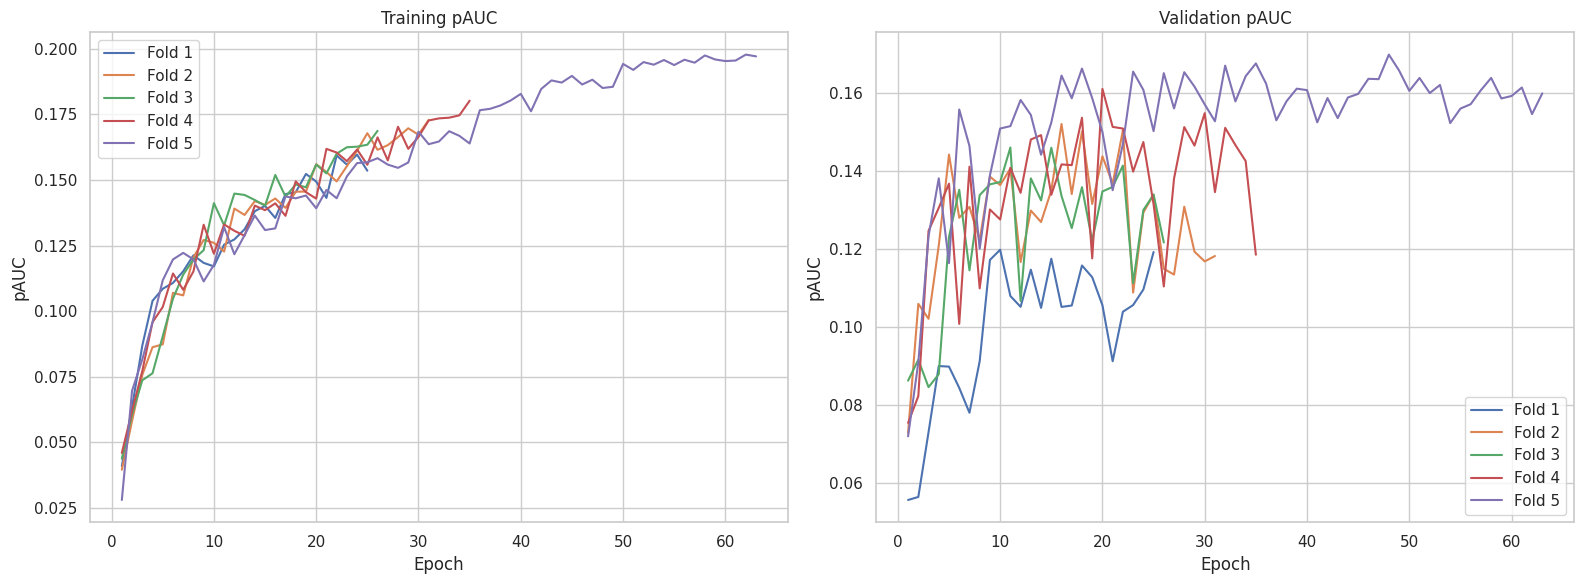

In [12]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(x='epoch', y='train_pauc', hue='Fold', data=histories, ax=axes[0])
axes[0].set_title('Training pAUC')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('pAUC')
axes[0].legend(loc='best')

sns.lineplot(x='epoch', y='val_pauc', hue='Fold', data=histories, ax=axes[1])
axes[1].set_title('Validation pAUC')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('pAUC')
axes[1].legend(loc='best')

fig.tight_layout()
plt.show()

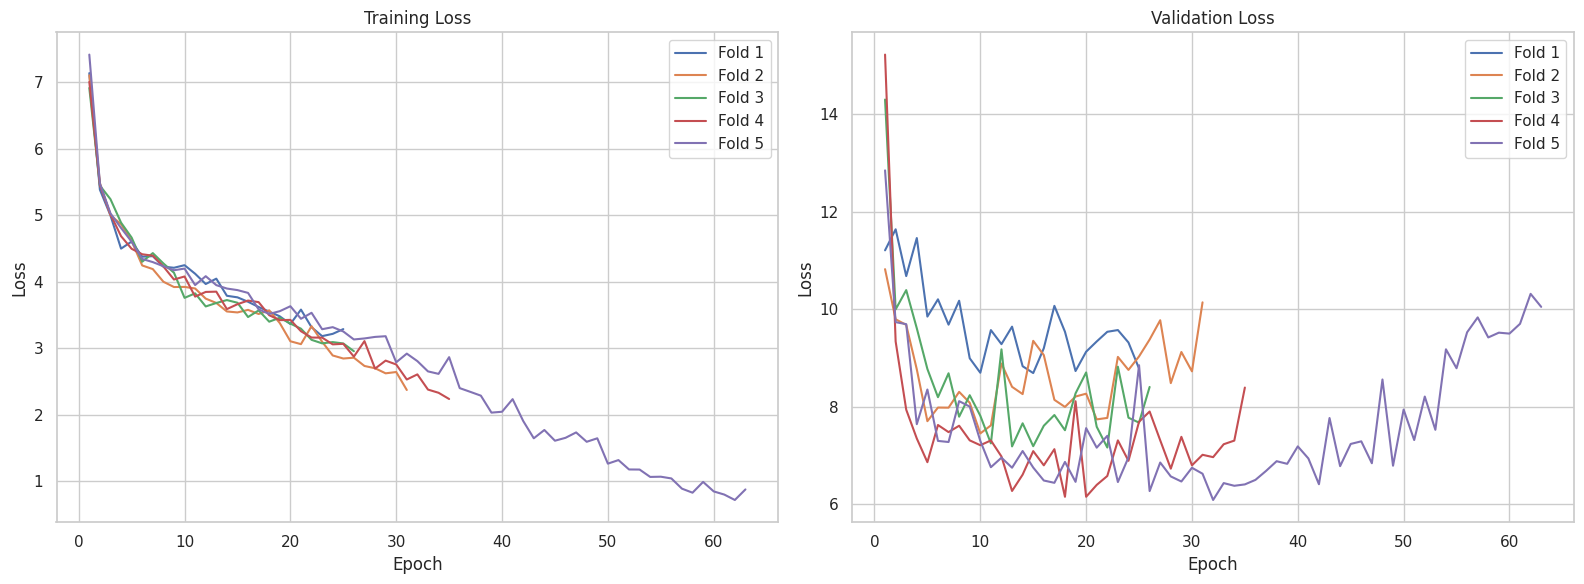

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(x='epoch', y='train_loss', hue='Fold', data=histories, ax=axes[0])
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='best')

sns.lineplot(x='epoch', y='val_loss', hue='Fold', data=histories, ax=axes[1])
axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='best')

fig.tight_layout()
plt.show()